In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.exceptions import ConvergenceWarning

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning) 

start = time.perf_counter()

In [2]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1016 non-null   object 
 1   SeasonNumber       1016 non-null   int64  
 2   SeasonVersion      1016 non-null   int64  
 3   Player             1016 non-null   object 
 4   MatchId            1016 non-null   object 
 5   Map                1016 non-null   object 
 6   Category           1016 non-null   object 
 7   Playlist           1016 non-null   object 
 8   Input              1016 non-null   object 
 9   Queue              1016 non-null   object 
 10  PreCsr             1016 non-null   int64  
 11  PostCsr            1016 non-null   int64  
 12  Rank               1016 non-null   int64  
 13  WasAtStart         1016 non-null   int64  
 14  WasAtEnd           1016 non-null   int64  
 15  WasInProgressJoin  1016 non-null   int64  
 16  Mmr                2 non

In [3]:
# General Fixes+Additions
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
# Ratios
df['DamageRatio'] = df['DamageDone'].replace(0, 1) / df['DamageTaken'].replace(0, 1)
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
df['Damage/KA'] = df['DamageDone'] / (df['Kills'] + df['Assists'])
# Per 10 Min
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
# Excess
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
# Kill Type
df['BodyPct'] = df['KillsBody'] / df['Kills'] *100
df['MeleePct'] = df['KillsMelee'] / df['Kills'] * 100
df['HSPct'] = df['KillsHeadshot'] / df['Kills'] * 100
df['GrenadePct'] = df['KillsGrenade'] / df['Kills'] * 100
df['PowerPct'] = df['KillsPower'] / df['Kills'] * 100



df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'PreCsr', 'PostCsr', 'ShotsFired', 'AssistsEmp',
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides', 'WasAtStart', 'WasAtEnd', 'AssistsDriver',
              'Perfects', 'WasInProgressJoin', 'VehicleDestroys', 'VehicleHijacks', 'AssistsCallout',
              'LengthSeconds', 'Rank', 'SeasonNumber', 'SeasonVersion', 'Map'],axis=1)
df = df.drop(['KillsBody','KillsMelee', 'KillsGrenade', 'KillsHeadshot', 'KillsPower'], axis=1)
# df = df.drop(['Kills','Deaths', 'Assists', 'DamageDone', 'DamageTaken'], axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 740 entries, 140 to 1015
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Outcome         740 non-null    int64  
 1   Accuracy        740 non-null    float64
 2   DamageDone      740 non-null    int64  
 3   DamageTaken     740 non-null    int64  
 4   KD              740 non-null    float64
 5   KDA             740 non-null    float64
 6   Kills           740 non-null    int64  
 7   Deaths          740 non-null    int64  
 8   Assists         740 non-null    int64  
 9   MaxSpree        740 non-null    int64  
 10  ExpectedKills   740 non-null    float64
 11  ExpectedDeaths  740 non-null    float64
 12  Score           740 non-null    int64  
 13  Medals          740 non-null    int64  
 14  LengthMinutes   740 non-null    float64
 15  DamageRatio     740 non-null    float64
 16  Damage/Kill     740 non-null    float64
 17  Damage/KA       740 non-null    

In [4]:
def cnt(df, col):
    count = df[col].count()
    return count
def sm(df, col):
    sum = df[col].sum()
    return sum
def avg(df, col, val=None):
    avg = round(sm(df, col) / cnt(df, col),val)
    return avg


In [5]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.430594
DmgT/10Min        0.362286
KD                0.318625
Deaths            0.314381
Damage/KA         0.285368
KDA               0.283263
DamageTaken       0.251756
ExcessDeaths      0.245521
ExpectedDeaths    0.211710
Damage/Kill       0.191106
Assists/10Min     0.163316
Kills/10Min       0.153068
LengthMinutes     0.136840
Accuracy          0.103573
DamageDone        0.093730
MaxSpree          0.085614
Assists           0.051391
BodyPct           0.049132
HSPct             0.042805
ExpectedKills     0.037291
DamageRatio       0.037151
Score             0.035225
Dmg/10Min         0.027723
ExcessKills       0.026634
GrenadePct        0.015523
Medals            0.013496
PowerPct          0.012849
Kills             0.009067
Shots/10Min       0.006968
MeleePct          0.000271
Name: Outcome, dtype: float64


In [6]:
# dfRR.hist(bins=15, figsize=(16, 12))
# plt.tight_layout()
# plt.show()

In [7]:
dfRR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Outcome,740.0,0.554054,0.497406,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,740.0,52.621095,5.558230,20.450000,49.110000,52.655000,55.840000,80.560000
DamageDone,740.0,5260.036486,1809.179967,619.000000,3913.000000,5030.000000,6491.000000,12673.000000
DamageTaken,740.0,4512.939189,1533.250814,0.000000,3475.500000,4344.000000,5542.750000,9962.000000
KD,740.0,1.266284,0.745499,0.270000,0.845000,1.120000,1.450000,10.000000
KDA,740.0,4.471554,5.739228,-10.000000,0.660000,4.330000,8.000000,31.000000
Kills,740.0,14.497297,6.268355,1.000000,10.000000,14.000000,18.000000,40.000000
Deaths,740.0,12.894595,5.120969,0.000000,9.000000,13.000000,16.000000,32.000000
Assists,740.0,8.612162,4.288590,0.000000,6.000000,8.000000,11.000000,28.000000
MaxSpree,740.0,3.925676,1.603832,1.000000,3.000000,4.000000,5.000000,12.000000


In [8]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [9]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (740, 30)
Y Shape: (740,)


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=27)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')
# print(X_train.columns)
print(f'Y Train Mean: {round(y_train.mean(),3)}')
print(f'Y Test Mean: {round(y_test.mean(),3)}')

X Train Shape: (592, 30)
X Test Shape: (148, 30)
Y Train Mean: 0.561
Y Test Mean: 0.527


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Accuracy', 'ExpectedKills', 'ExpectedDeaths', 'KD', 
                                    'KDA', 'MaxSpree', 'Deaths', 'Assists', 'Kills', 'DamageDone', 
                                    'DamageTaken', 'Score', 'Medals', 'LengthMinutes', 
                                    'DamageRatio', 'Damage/Kill', 'Damage/KA', 
                                    'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min',
                                    'DmgT/10Min', 'Shots/10Min', 'ExcessKills', 'ExcessDeaths',
                                    'BodyPct', 'MeleePct', 'HSPct', 'GrenadePct', 'PowerPct'])])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)


print(f'X Train Processed Shape: {X_train_preprocessed.shape}')
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Processed Shape: {X_test_preprocessed.shape}')
# X_train_preprocessed.head()

X Train Processed Shape: (592, 30)
X Train Shape: (592, 30)
X Test Processed Shape: (148, 30)


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, log_loss, classification_report, confusion_matrix
MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
  y_pred = model.predict(X_test_preprocessed)
  # Calculate regression metrics
  acc = model.score(X_test_preprocessed, y_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
  ll = log_loss(y_test,y_pred)
  clRep = classification_report(y_test, y_pred)
  confM = confusion_matrix(y_test, y_pred)

  # Print the metrics with newline characters
  print("Acc: {:.3f}".format(acc))
  print("MAE: {:.2f}".format(mae))
  print("MSE: {:.2f}".format(mse))
  print("RMSE: {:.2f}".format(rmse))
  print("R^2 Score: {:.2f}".format(r2))
  print("OOS R^2 Score: {:.2f}".format(oosr2))
  print("Log Loss: {:.2f}".format(ll))
  print('---------------------------------------------------------')
  print(clRep)
  print('---------------------------------------------------------') 
  # print(confM)
  # print('---------------------------------------------------------') 
  return ''

def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

def coefs(mod):
  # Get the coefficients
  coefficients = mod.coef_[0]

  # Create a dictionary with feature names and their corresponding coefficients
  feature_coefficients = dict(zip(X_train.columns, coefficients))

  # Sort features by coefficients in descending order
  sorted_features = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=False)

  # Print or analyze the top 10 sorted feature coefficients
  print("Top 10 Sorted Feature Coefficients:")
  for feature, coefficient in sorted_features[:10]:
      print(f"{feature}: {coefficient:.2f}")


## Logistic Regression

In [13]:
# Unregularized Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(penalty=None)
logreg.fit(X_train_preprocessed, y_train)

print(f'Unregularized Logistic Regression Accuracy: {logreg.score(X_test_preprocessed, y_test)}')
print(ResultsOut(logreg))
print(coefs(logreg))

Unregularized Logistic Regression Accuracy: 0.8513513513513513
Acc: 0.851
MAE: 0.15
MSE: 0.15
RMSE: 0.39
R^2 Score: 0.40
OOS R^2 Score: 0.41
Log Loss: 5.36
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        70
           1       0.85      0.87      0.86        78

    accuracy                           0.85       148
   macro avg       0.85      0.85      0.85       148
weighted avg       0.85      0.85      0.85       148

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
PowerPct: -0.01
Shots/10Min: 0.03
MeleePct: 0.03
BodyPct: 0.04
KD: -0.08
Medals: -0.08
KDA: -0.14
HSPct: -0.14
Damage/Kill: 0.16
GrenadePct: 0.16
None


## Ridge

In [14]:
# Ridge
# Need to find best params for param grid

C_grid = [10**-3,10**-2,10**-1,10**0,10**1,10**2]

param_grid={'C':C_grid}
ridge_cv = GridSearchCV(LogisticRegression(penalty='l2',solver='saga'),
                                          param_grid=param_grid,cv=5)
ridge_cv.fit(X_train_preprocessed,y_train)

print(ridge_cv.best_estimator_)
print(f'Ridge Accuracy: {ridge_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(ridge_cv))
print(ResultsOut(ridge_cv))
print(coefs(ridge_cv.best_estimator_))


LogisticRegression(C=100, solver='saga')
Ridge Accuracy: 0.8513513513513513
   C_param  Accuracy
0    0.001  0.652072
1    0.010  0.716322
2    0.100  0.763609
3    1.000  0.772041
4   10.000  0.778792
5  100.000  0.780473

Acc: 0.851
MAE: 0.15
MSE: 0.15
RMSE: 0.39
R^2 Score: 0.40
OOS R^2 Score: 0.41
Log Loss: 5.36
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        70
           1       0.85      0.87      0.86        78

    accuracy                           0.85       148
   macro avg       0.85      0.85      0.85       148
weighted avg       0.85      0.85      0.85       148

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
Medals: -0.01
ExpectedDeaths: 0.02
Assists/10Min: 0.02
DamageRatio: -0.03
MeleePct: 0.03
Shots/10Min: 0.04
BodyPct: 0.04
DmgT/10Min: -0.06
PowerPct: -0.07
Dmg/10Min: -0.08
None


## Lasso

In [15]:
# Lasso

param_grid={'C':C_grid}
lasso_cv = GridSearchCV(LogisticRegression(penalty='l1',solver='saga'),
                                          param_grid=param_grid,cv=5)
lasso_cv.fit(X_train_preprocessed,y_train)

print(lasso_cv.best_estimator_)
print(f'Lasso Accuracy: {lasso_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(lasso_cv))
print(ResultsOut(lasso_cv))
print(coefs(lasso_cv.best_estimator_))

LogisticRegression(C=10, penalty='l1', solver='saga')
Lasso Accuracy: 0.8513513513513513
   C_param  Accuracy
0    0.001  0.560803
1    0.010  0.560803
2    0.100  0.738342
3    1.000  0.777097
4   10.000  0.780473
5  100.000  0.780473

Acc: 0.851
MAE: 0.15
MSE: 0.15
RMSE: 0.39
R^2 Score: 0.40
OOS R^2 Score: 0.41
Log Loss: 5.36
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        70
           1       0.85      0.87      0.86        78

    accuracy                           0.85       148
   macro avg       0.85      0.85      0.85       148
weighted avg       0.85      0.85      0.85       148

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
DamageRatio: -0.00
Medals: -0.00
ExpectedDeaths: 0.01
Assists/10Min: 0.01
MeleePct: 0.03
BodyPct: 0.03
Shots/10Min: 0.03
DmgT/10Min: -0.05
Dmg/10Min: -0.07
PowerPct: -0.07
None


## ElasticNet

In [16]:
# ElasticNet

param_grid2={'C':C_grid,'l1_ratio':[.25, .5, .75]}

elastic_cv = GridSearchCV(LogisticRegression(penalty='elasticnet',solver='saga'),
                                            param_grid=param_grid2,cv=5)
elastic_cv.fit(X_train_preprocessed,y_train)

print(elastic_cv.best_estimator_)
print(f'ElasticNet Accuracy: {elastic_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(elastic_cv))
print(ResultsOut(elastic_cv))
print(coefs(elastic_cv.best_estimator_))



LogisticRegression(C=10, l1_ratio=0.25, penalty='elasticnet', solver='saga')
ElasticNet Accuracy: 0.8513513513513513
    C_param  l1_ratio_param  Accuracy
0     0.001            0.25  0.560803
1     0.001            0.50  0.560803
2     0.001            0.75  0.560803
3     0.010            0.25  0.697750
4     0.010            0.50  0.680772
5     0.010            0.75  0.613104
6     0.100            0.25  0.760262
7     0.100            0.50  0.756872
8     0.100            0.75  0.753539
9     1.000            0.25  0.775402
10    1.000            0.50  0.773722
11    1.000            0.75  0.775417
12   10.000            0.25  0.780473
13   10.000            0.50  0.780473
14   10.000            0.75  0.780473
15  100.000            0.25  0.780473
16  100.000            0.50  0.778792
17  100.000            0.75  0.780473

Acc: 0.851
MAE: 0.15
MSE: 0.15
RMSE: 0.39
R^2 Score: 0.40
OOS R^2 Score: 0.41
Log Loss: 5.36
---------------------------------------------------------
         

## K-Nearest Neighbours

In [17]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1,50,3))
param_grid = {'n_neighbors': k_values}

knn_cv = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knn_cv.fit(X_train_preprocessed,y_train)

print(knn_cv.best_estimator_)
print(f'K-Nearest Neighbors Accuracy: {knn_cv.score(X_test_preprocessed, y_test)}')
knn_cv.cv_results_
print(paramResults(knn_cv))
print(ResultsOut(knn_cv))



KNeighborsClassifier(n_neighbors=40)
K-Nearest Neighbors Accuracy: 0.7027027027027027
    n_neighbors_param  Accuracy
0                   1  0.658681
1                   4  0.662099
2                   7  0.685871
3                  10  0.665646
4                  13  0.689289
5                  16  0.690970
6                  19  0.692651
7                  22  0.684205
8                  25  0.685899
9                  28  0.684162
10                 31  0.674049
11                 34  0.689218
12                 37  0.695955
13                 40  0.697707
14                 43  0.692636
15                 46  0.695998
16                 49  0.690913

Acc: 0.703
MAE: 0.30
MSE: 0.30
RMSE: 0.55
R^2 Score: -0.19
OOS R^2 Score: -0.19
Log Loss: 10.72
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.63      0.67        70
           1       0.70      0.77      0.73        78

    accuracy       

## Random Forest

In [18]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [100,300,500],'max_depth': [10, 15, 20]}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=69,max_features='sqrt'),
                                                     cv=5, param_grid=param_grid_rf,n_jobs=-1)
rf_cv.fit(X_train_preprocessed, y_train)

print(rf_cv.best_estimator_)
print(f'Random Forest Accuracy: {rf_cv.score(X_test_preprocessed, y_test)}')
rf_cv.cv_results_
paramResults(rf_cv)

RandomForestClassifier(max_depth=15, random_state=69)
Random Forest Accuracy: 0.7094594594594594
   max_depth_param  n_estimators_param  Accuracy
0               10                 100  0.692665
1               10                 300  0.704501
2               10                 500  0.707834
3               15                 100  0.717960
4               15                 300  0.714599
5               15                 500  0.714613
6               20                 100  0.714556
7               20                 300  0.712918
8               20                 500  0.709543


''

In [19]:
ResultsOut(rf_cv)

Acc: 0.709
MAE: 0.29
MSE: 0.29
RMSE: 0.54
R^2 Score: -0.17
OOS R^2 Score: -0.16
Log Loss: 10.47
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.66      0.68        70
           1       0.71      0.76      0.73        78

    accuracy                           0.71       148
   macro avg       0.71      0.71      0.71       148
weighted avg       0.71      0.71      0.71       148

---------------------------------------------------------


''

<Axes: >

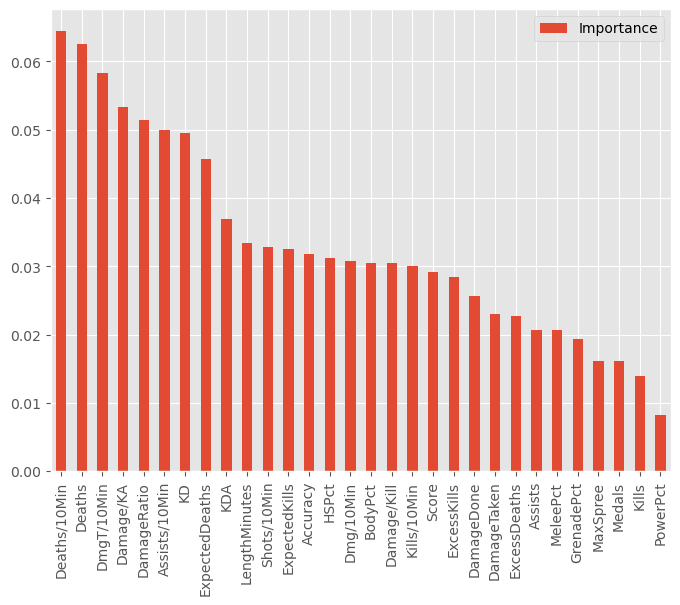

In [20]:
feat_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Gradient Boosted Trees

In [21]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbrt = {'n_estimators': [100,300,500],'learning_rate': [0.01,0.1],'max_depth': [2,4,6], 'subsample': [0.5,0.6,0.8,1]}
GBRT = GridSearchCV(estimator=GradientBoostingClassifier(random_state=69),
                    cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
GBRT.fit(X_train_preprocessed, y_train)

print(GBRT.best_estimator_)
print(f'Gradient Boosed Trees Accuracy: {GBRT.score(X_test_preprocessed, y_test)}')
GBRT.cv_results_
paramResults(GBRT)

GradientBoostingClassifier(max_depth=2, n_estimators=500, random_state=69,
                           subsample=0.6)
Gradient Boosed Trees Accuracy: 0.722972972972973
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                2                 100              0.5   
1                  0.01                2                 100              0.6   
2                  0.01                2                 100              0.8   
3                  0.01                2                 100              1.0   
4                  0.01                2                 300              0.5   
..                  ...              ...                 ...              ...   
67                 0.10                6                 300              1.0   
68                 0.10                6                 500              0.5   
69                 0.10                6                 500              0.6   
70                 0.10

''

In [22]:
ResultsOut(GBRT)

Acc: 0.723
MAE: 0.28
MSE: 0.28
RMSE: 0.53
R^2 Score: -0.11
OOS R^2 Score: -0.11
Log Loss: 9.99
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.70      0.71        70
           1       0.73      0.74      0.74        78

    accuracy                           0.72       148
   macro avg       0.72      0.72      0.72       148
weighted avg       0.72      0.72      0.72       148

---------------------------------------------------------


''

<Axes: >

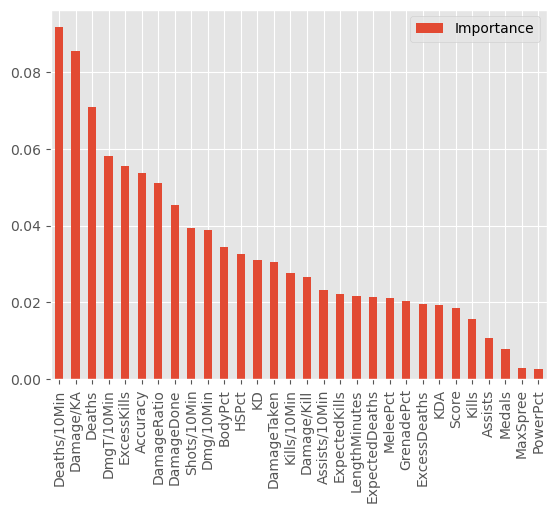

In [23]:
feat_importances = pd.DataFrame(GBRT.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

## XGBoost

In [24]:
from xgboost import XGBClassifier

param_grid_xgb = {'n_estimators': [100,200,300,400,500],'learning_rate': [0.01,0.05,0.1,0.15],'max_depth': [1,2,3,4,5]}
XGB = GridSearchCV(estimator=XGBClassifier(random_state=69), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
XGB.fit(X_train_preprocessed, y_train)

print(XGB.best_estimator_)
print(f'XGBoost Accuracy: {XGB.score(X_test_preprocessed, y_test)}')
paramResults(XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)
XGBoost Accuracy: 0.7432432432432432
    learning_rate_param  max_depth_param  n_estimators_param  Accuracy
0                  0.01                1                 100  0.679120
1                  0.01                1                 200  0.696040
2   

''

In [25]:
ResultsOut(XGB)

Acc: 0.743
MAE: 0.26
MSE: 0.26
RMSE: 0.51
R^2 Score: -0.03
OOS R^2 Score: -0.03
Log Loss: 9.25
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.71      0.72        70
           1       0.75      0.77      0.76        78

    accuracy                           0.74       148
   macro avg       0.74      0.74      0.74       148
weighted avg       0.74      0.74      0.74       148

---------------------------------------------------------


''

<Axes: >

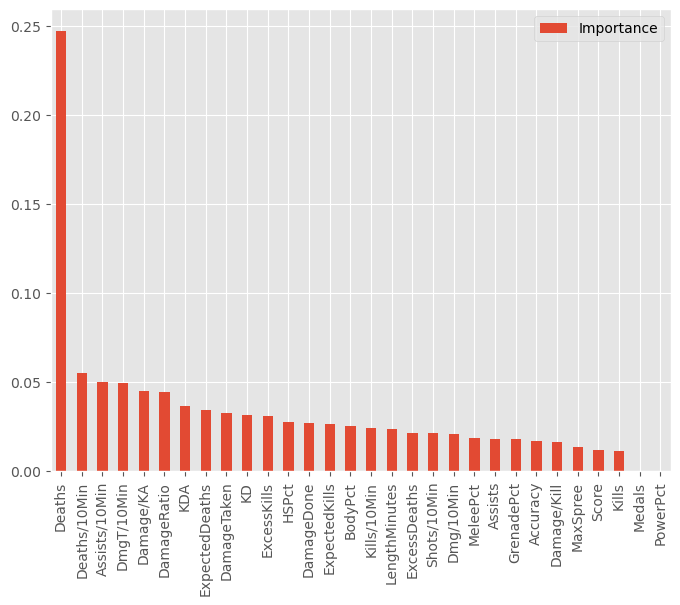

In [26]:
feat_importances = pd.DataFrame(XGB.best_estimator_.feature_importances_[:32], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Neural Net

In [27]:
from sklearn.neural_network import MLPClassifier

param_grid_mlpc = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'],
                'learning_rate': ['constant', 'invscaling', 'adaptive'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
mlpc = GridSearchCV(estimator=MLPClassifier(random_state=61), cv=5, param_grid=param_grid_mlpc, n_jobs=-1)

mlpc.fit(X_train_preprocessed, y_train)
print(mlpc.best_estimator_)
print(f'Neural Net Accuracy: {mlpc.score(X_test_preprocessed, y_test)}')

/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaron

MLPClassifier(alpha=0.001, random_state=61)
Neural Net Accuracy: 0.7837837837837838


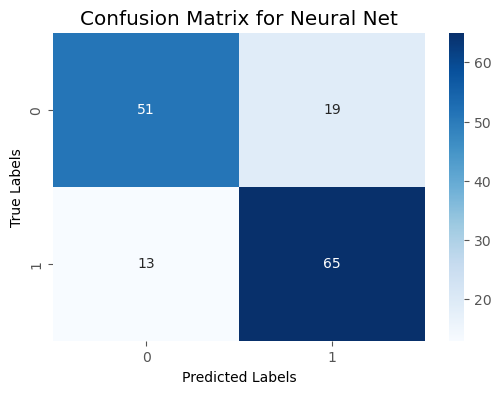

The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.


<Axes: >

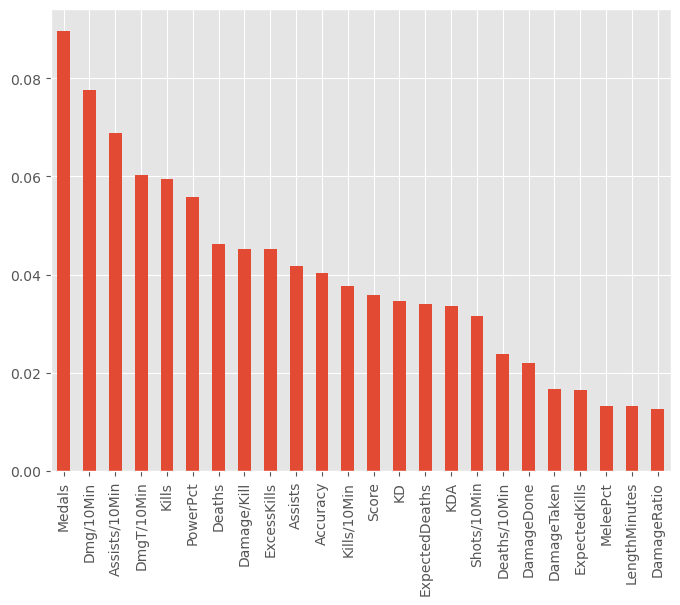

In [28]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix for the Neural Net
conf_matrix = confusion_matrix(y_test, mlpc.predict(X_test_preprocessed))
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Neural Net')
plt.show()

print("The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.")
feat_importances_mlpc = pd.DataFrame(mlpc.best_estimator_.coefs_[0].flatten()[:30], index=X_train.columns, columns=["Importance"])
feat_importances_mlpc = feat_importances_mlpc.abs().sum(axis=1)
feat_importances_mlpc = feat_importances_mlpc / feat_importances_mlpc.sum()
feat_importances_mlpc = feat_importances_mlpc.sort_values(ascending=False)[:24]
feat_importances_mlpc.plot(kind='bar', figsize=(8,6))

## Torch NN

In [29]:
# y_train.shape

In [30]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np

# # Assuming X_train_preprocessed and y_train are your NumPy arrays
# y_train_array = y_train.values
# X_train_preprocessed_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float)
# y_train_tensor = torch.tensor(y_train_array, dtype=torch.long)

# class SimpleNeuralNet(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(SimpleNeuralNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.softmax(x)
#         return x

# # Instantiate the model
# input_size = 30  # Replace with the actual input size
# hidden_size = 15 # Replace with the desired hidden layer size
# output_size = 2  # Replace with the actual output size
# model = SimpleNeuralNet(input_size, hidden_size, output_size)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# # Train the model on your trainsets
# # Replace X_train and y_train with your actual train data
# # Replace num_epochs with the desired number of training epochs
# losses = []
# accuracies = []
# prev_loss = float('inf')
# for epoch in range(100000):
#     optimizer.zero_grad()
#     outputs = model(X_train_preprocessed_tensor)
#     loss = criterion(outputs, y_train_tensor)
#     if loss >= prev_loss:
#         break
#     prev_loss = loss
#     loss.backward()
#     optimizer.step()
#     losses.append(loss.item())
    
#     # Calculate training accuracy
#     with torch.no_grad():
#         predicted = torch.argmax(outputs, 1)
#         correct = (predicted == y_train_tensor).sum().item()
#         accuracy = correct / y_train_tensor.size(0)
#         accuracies.append(accuracy)

In [31]:
# optimizer = optim.LBFGS(model.parameters(), lr=0.01)

# def closure():
#     optimizer.zero_grad()
#     outputs = model(X_train_preprocessed_tensor)
#     loss = criterion(outputs, y_train_tensor)
#     loss.backward()
#     return loss

# # Train the model using the LBFGS optimizer with the closure function
# for epoch in range(100000):
#     optimizer.step(closure)

In [32]:
# # Assuming X_test_preprocessed and y_test are your test data
# X_test_preprocessed_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# # Evaluate the model on the test set
# with torch.no_grad():
#     test_outputs = model(X_test_preprocessed_tensor)
#     test_loss = criterion(test_outputs, y_test_tensor)
#     test_predicted = torch.argmax(test_outputs, 1)
#     test_correct = (test_predicted == y_test_tensor).sum().item()
#     test_accuracy = test_correct / y_test_tensor.size(0)

# print(f'Test Loss: {test_loss.item()}')
# print(f'Test Accuracy: {test_accuracy}')
# print(f'Epochs: {len(losses)}')

In [33]:
# import matplotlib.pyplot as plt
# epochs = range(1, len(losses) + 1)

# # Plotting training and validation losses
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, losses, label='Training Loss')
# plt.title('Training and Validation Loss over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# # Plotting training and validation accuracies
# plt.subplot(1, 2, 2)
# plt.plot(epochs, accuracies, label='Training Accuracy')
# plt.title('Training and Validation Accuracy over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()


,Model,ACC,MAE,MSE,RMSE,R2,OOS R2,Log Loss
0,Logistic Regression,0.851,0.149,0.149,0.386,0.404,0.406,5.358
1,Ridge,0.851,0.149,0.149,0.386,0.404,0.406,5.358
2,Lasso,0.851,0.149,0.149,0.386,0.404,0.406,5.358
3,ElasticNet,0.851,0.149,0.149,0.386,0.404,0.406,5.358
4,MLPC,0.784,0.216,0.216,0.465,0.133,0.137,7.793
5,XGBoost,0.743,0.257,0.257,0.507,-0.030,-0.025,9.254
6,Gradient Boosted Trees,0.723,0.277,0.277,0.526,-0.111,-0.106,9.985
7,Random Forest,0.709,0.291,0.291,0.539,-0.166,-0.160,10.472
8,K-Nearest Neighbors,0.703,0.297,0.297,0.545,-0.193,-0.187,10.716


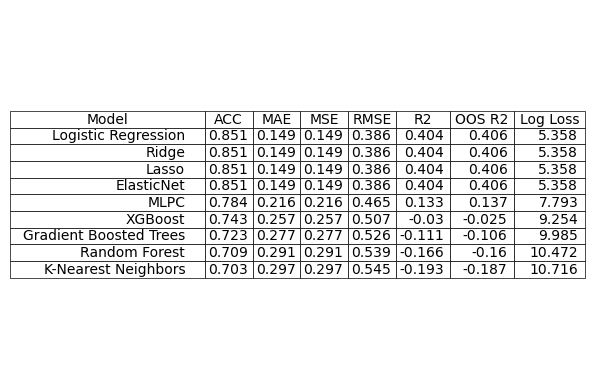

In [38]:
modelss = [logreg,ridge_cv,lasso_cv,elastic_cv,knn_cv,rf_cv,GBRT,XGB,mlpc]
model_namess = ['Logistic Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted Trees', 'XGBoost', 'MLPC']
from datetime import datetime
date = datetime.now().strftime("%m%d")

def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'ACC' ,'MAE', 'MSE', 'RMSE', 'R2', 'OOS R2', 'Log Loss'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_preprocessed)
        
        # Calculate regression metrics
        acc = round(model.score(X_test_preprocessed, y_test),3)
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        ll = round(log_loss(y_test,y_pred),3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i],acc, mae, mse, rmse, r2, oosr2, ll]
    
    metrics_df = metrics_df.sort_values('ACC', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots()
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                     cellLoc='right', loc='center')
    table.auto_set_font_size(True)
    table.auto_set_column_width(col=list(range(len(metrics_df.columns))))
    ax.axis('off')
    plt.savefig(f'ModelResults/ModelResults{date}.png', dpi=300, bbox_inches='tight')
    
    return metrics_df

saveResults(modelss,model_namess)


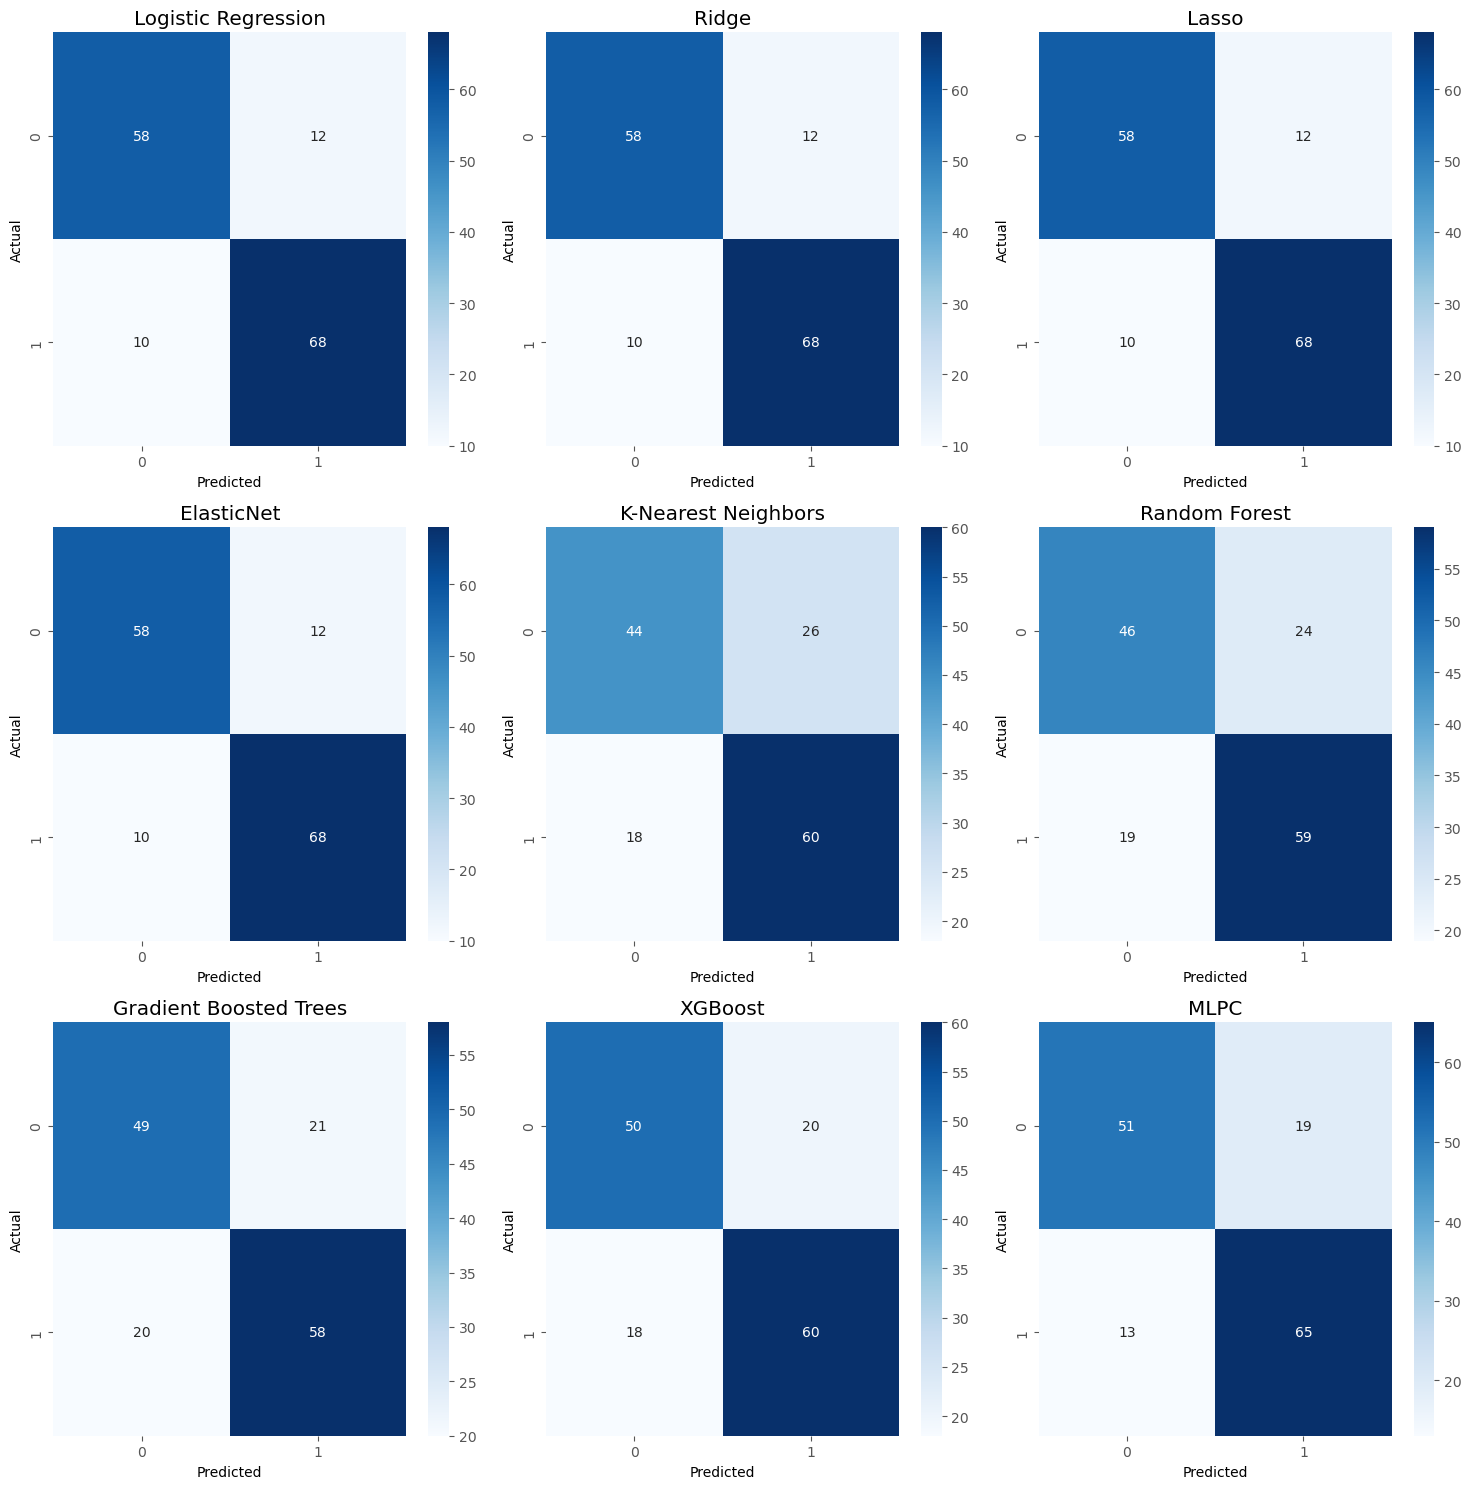

In [39]:
# Assuming X_test_preprocessed and y_test are your test data
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, (model, model_name) in enumerate(zip(modelss, model_namess)):
    y_pred = model.predict(X_test_preprocessed)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(model_name)
    axs[i//3, i%3].set_xlabel('Predicted')
    axs[i//3, i%3].set_ylabel('Actual')

plt.tight_layout()
plt.savefig(f'Plots/ConfusionMatrixMultigraph{date}.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
print(f'Runtime: {round(time.perf_counter() - start,2)}s')

Runtime: 153.45s


In [37]:
X_trainp_df = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)
round(X_trainp_df.describe().transpose(),3).sort_values(by='max',ascending=False)

,count,mean,std,min,25%,50%,75%,max
DamageRatio,592.0,-0.0,1.001,-0.062,-0.049,-0.044,-0.037,24.298
KD,592.0,-0.0,1.001,-1.339,-0.556,-0.192,0.267,11.788
Damage/Kill,592.0,-0.0,1.001,-1.873,-0.645,-0.234,0.393,6.221
Shots/10Min,592.0,0.0,1.001,-3.601,-0.602,-0.012,0.578,5.908
PowerPct,592.0,0.0,1.001,-0.364,-0.364,-0.364,-0.364,5.888
GrenadePct,592.0,-0.0,1.001,-0.864,-0.864,-0.180,0.503,5.287
Damage/KA,592.0,-0.0,1.001,-2.047,-0.669,-0.144,0.496,5.268
Score,592.0,0.0,1.001,-2.071,-0.772,-0.122,0.634,5.074
Assists/10Min,592.0,0.0,1.001,-2.531,-0.658,-0.058,0.605,5.007
Accuracy,592.0,-0.0,1.001,-5.699,-0.614,0.006,0.583,4.913
